# Module Information Scraper
This code is to scrape assessment details from UCD module-by-module. From there, we can find out how vulnerable UCD is to ChatGPT and other similar AI helpers. First we will need to import some packages to do this.

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import pathlib as Path
import html5lib
import json

Next we will need to set the path to the datasets that we will use. This currently pulls in a specific file, that of MODULES.csv, which has all collected module information for the school of Engineering and Architecture. However, this could easily be changed to analyze sub-schools or other schools.

In [2]:
dir_raw=Path.Path("Datasets")

moduleCodes= dir_raw / "MODULES.csv"

modules=pd.read_csv(moduleCodes)

modules

,Code,Module,School
0,DSCY10060,"Energy, Climate Change & Policy",EEE
1,EEEN10010,Electronic and Electrical Engineering I,EEE
2,EEEN10020,Robotics Design Project,EEE
3,EEEN20010,Computer Engineering,EEE
4,EEEN20020,Electrical and Electronic Circuits,EEE
...,...,...,...
519,MEEN50050,Creative Thinking & Innovation,MME
520,MEEN50060,Research Techniques Space Eng,MME
521,MEEN50070,Industrial Research I,MME
522,MEEN50080,Industrial Research II,MME


The module descriptor scraper pulls all module descriptor information from the UCD module website. This includes information such as who runs the module, and importantly for our analysis, the number of credits for each module.

In [3]:
def module_descriptor_scraper(url, level=None, school=None):
    #url= "https://hub.ucd.ie/usis/!W_HU_MENU.P_PUBLISH?p_tag=MODULE&MODULE=" + modules.iloc[0]["Code"]

    request=requests.get(url)
    soup=BeautifulSoup(request.content, 'html.parser')

#print(soup)
#Create all_h1_tags as empty list
    descriptor_list={}

# Set all_h1_tags to all h1 tags of the soup
    for element in soup.select('dl'):
        credit_list=element.text
        for items in zip(soup.select('dt'), soup.select('dd')):
            #print(items[0].text + " " + items[1].text)
            descriptor_list[items[0].text]=items[1].text
        #descriptor_item.append(items[1])
        
#print("%d , %d" %(len(descriptor_type),len(descriptor_item)))

    
    module_descriptor=pd.Series(descriptor_list)
    module_descriptor["Credits:"]=pd.to_numeric(module_descriptor["Credits:"], errors='coerce')
    #print(module_descriptor)
#print(element)

    filtered=False
    
    #If filters exist, check that the module is not filtered out
    if (level != None):
        filtered= (pd.to_numeric(module_descriptor["Level:"].split('(')[0], errors='ignore') != level)
                   
    #If it wasn't filtered out by level, check if it is filtered out by school
    if (filtered == False) and (school != None):
        filtered = (module_descriptor["School:"] != school)
                   


    return module_descriptor, filtered

In [29]:
#This asserts that the filter works correctly
def assert_filtered(module_descriptors, level=None, school=None):
    all_descriptors=pd.concat(module_descriptors)
    
    if level !=None:
        assert (all_descriptors["Level:"].nunique() == 1)
    if school != None:
        assert (all_descriptors["School:"].nunique() == 1)
        
    print(all_descriptors["School:"].unique())
    return all_descriptors["School:"].nunique(), all_descriptors["Level:"].nunique()

The below code collects all module assessment and module descriptor information into two lists. It also creates a "Scaled % of Final Grade" column in the asssessment table. This weights the assessment based on the number of credits the module has overall. In this way, the median and normal amount of credits, 5.0, has assessments weighting that add up to 100%. Those above and below are given assessment weightings that scale with how much more or less they are worth then a normal module - a 10 credit module will have assessments that add up to 200%, because they are worth twice the amount as a normal module.

Error module details are stored for inspection later, to see why they occurred. The code continues on even if errors occur, after having stored these details it simply proceeds to the next module.

In [5]:
def save_module_files(module_assessments, module_descriptors, level, school):
    #The directory to save outputs to
    dir_output=Path.Path("ModuleInformation")
    dir_output.mkdir(parents=True, exist_ok=True)
    
    
    #filenames={module_assessments: "assessments", module_descriptors:"descriptors"}
    subdirectory=""
    #Save the file in its desired format
    if level != None:
        subdirectory+="Level=%d" %(level)
        
    if school != None:
        subdirectory+="_School="+school.replace(" ", "-")
    
    #if the modules have been filtered, and thus belong in a sub directory, make that directory
    if len(subdirectory) > 0:
        dir_output=dir_output / subdirectory
        dir_output.mkdir(parents=True, exist_ok=True)
        
    #Save our two module detail files
    with open(dir_output / "assessments.json", 'w') as outfile:
        if len(module_assessments) > 2:
            module_assessments=pd.concat(module_assessments, ignore_index=True)
            #print(module_assessments)
        print("saving to %s" % dir_output)
        outfile.write(json.dumps(module_assessments.to_json()))
        
    with open(dir_output / "descriptors.json", 'w') as outfile:
        print("saving to %s" % dir_output)
        if len(module_descriptors) > 2:
            module_descriptors=pd.DataFrame(module_descriptors)
        outfile.write(json.dumps(module_descriptors.to_json()))

In [30]:
#This functiom will allow school and year functions to be placed on it
def collector(level=None, school=None):
    #This stores module information
    module_assessments=[]
    module_descriptors=[]

    #This stores error module information
    error_modules=[]
    error_module_descriptors=[]

    for i in modules.iloc:
        print(".",end="")
        url= "https://hub.ucd.ie/usis/!W_HU_MENU.P_PUBLISH?p_tag=MODULE&MODULE=" + i["Code"]

        #Get the module descriptor
        descriptor, filtered=module_descriptor_scraper(url, level=level, school=school)
        #If the module is in violation of the filters, continue to the next without saving
        if filtered==True:
            continue
        #Use pandas to read in the asssessment html tables too
        table=pd.read_html(url, match="Description")
        
        #print(descriptor)
        #Get the first table, and turn it into a dataframe
        df=pd.DataFrame(table[0])
        df["Assessment Type"] = df['Description'].str.split(':').str[0]
        try:
            df["Scaled % of Final Grade"]= df['% of Final Grade'].apply(lambda x: x * (descriptor["Credits:"]/5.0))
        except:
            print("\nERROR MODULE DETECTED.")
            #print(df["% of Final Grade"])
            #print(descriptor["Credits:"])
            print("Module may need to be inspected, saving information as an error module and continuing without it")
        
            error_modules.append(df)
            error_module_descriptors.append(descriptor)
            #Continue after noting and saving the error
            continue
        
        #Append the dataframe to the module assessments list
        module_assessments.append(df)
        module_descriptors.append(descriptor)
    
    #This asserts that the filters were properly imposed, if imposed at all
    num_schools, num_levels=assert_filtered(module_descriptors, level, school)

    print("\nFINISHED, SCRAPED DETAILS ON %d MODULES, OVER %d SCHOOLS AND %d LEVELS" %(len(module_assessments), num_schools, num_levels))
    
    #Save the output files
    save_module_files(module_assessments, module_descriptors, level, school)
    
    return module_assessments, module_descriptors, error_modules, error_module_descriptors

#Run the above function in its base form
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector()

.......................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..........................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
...................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.....
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module 

In [7]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(level=1)

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
FINISHED, SCRAPED DETAILS ON 32 MODULES
saving to ModuleInformation\Level=1
saving to ModuleInformation\Level=1


In [8]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(level=2)

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
FINISHED, SCRAPED DETAILS ON 55 MODULES
saving to ModuleInformation\Level=2
saving to ModuleInformation\Level=2


In [9]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(level=3)

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
FINISHED, SCRAPED DETAILS ON 88 MODULES
saving to ModuleInformation\Level=3
saving to ModuleInformation\Level=3


In [10]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(level=4)

.......................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..........................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
...................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.....
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module 

In [11]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(level=5)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
....
FINISHED, SCRAPED DETAILS ON 12 MODULES
saving to ModuleInformation\Level=5
saving to ModuleInformation\Level=5


In [31]:
#Run the collector function to only collect level 1 modules in the college of Engineering and Architecture
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Mechanical & Materials Eng")

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
........................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
..................

In [ ]:
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Civil Engineering")

.......................................................................................................................
ERROR MODULE DETECTED.
Module may need to be inspected, saving information as an error module and continuing without it
.........................................................................

In [ ]:
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Chem & Bioprocess Engineering")

In [ ]:
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Biosystems & Food Engineering")

In [ ]:
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Architecture, Plan & Env Pol")

In [ ]:
module_assessments, module_descriptors, error_modules, error_module_descriptors=collector(school="Electrical & Electronic Eng")

In [12]:
#Inspect the error modules just in case
for i, error in enumerate(zip(error_modules, error_module_descriptors)):
    print("********ERROR COUNT %d*********" %i)
    print(error[0])
    print(error[1])
    

********ERROR COUNT 0*********
         Description             Timing     Open Book Exam    Component Scale  \
0  Not yet recorded.  Not yet recorded.  Not yet recorded.  Not yet recorded.   

  Must Pass Component   % of Final Grade    Assessment Type  
0   Not yet recorded.  Not yet recorded.  Not yet recorded.  
Subject:                                   Mechanical Engineering
College:                               Engineering & Architecture
School:                                Mechanical & Materials Eng
Level:                                               5 (Doctoral)
Credits:                                                     10.0
Credit Split by Trimester:                       Autumn 5Spring 5
Trimester:                         2 Trimester duration (Aut-Spr)
Module Coordinator:                   Professor Michael Gilchrist
Mode of Delivery:                                Not yet recorded
Internship Module:                                             No
Clinical/ Fieldwork/ P

Next we combine all the modules assessment information together, ready for later aggregation and analysis.

In [13]:
aggreg_modules=pd.concat(module_assessments)

aggreg_modules

,Description,Timing,Open Book Exam,Component Scale,Must Pass Component,% of Final Grade,Assessment Type,Scaled % of Final Grade
0,Assignment: Three reports.,Throughout the Trimester,NaN,Graded,No,100,Assignment,200.0
0,Assignment: Three reports.,Throughout the Trimester,NaN,Graded,No,100,Assignment,400.0
0,Assignment: Seminar critique,Unspecified,NaN,Pass/Fail Grade Scale,Yes,100,Assignment,50.0
0,Continuous Assessment: Report on Placement Act...,Coursework (End of Trimester),NaN,Pass/Fail Grade Scale,Yes,100,Continuous Assessment,200.0
0,Group Project: Group Project and Presentation,Throughout the Trimester,NaN,Pass/Fail Grade Scale,No,50,Group Project,100.0
1,Project: Individual Project,Throughout the Trimester,NaN,Pass/Fail Grade Scale,No,50,Project,100.0
0,Continuous Assessment: Assessment is 100% cour...,Throughout the Trimester,NaN,Pass/Fail Grade Scale,No,100,Continuous Assessment,200.0
0,Group Project: Co-written essay,Throughout the Trimester,NaN,Pass/Fail Grade Scale,No,25,Group Project,50.0
1,Presentation: Group presentation,Throughout the Trimester,NaN,Pass/Fail Grade Scale,No,25,Presentation,50.0
2,Assignment: Individual project,Throughout the Trimester,NaN,Pass/Fail Grade Scale,No,50,Assignment,100.0


In [14]:
assessments=aggreg_modules[["Assessment Type", "% of Final Grade"]]

#This is the dataset cleaning, so that they are ready for presentation
assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
assessments=assessments.dropna()
assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")

assessments

C:\Users\catha\AppData\Local\Temp\ipykernel_17784\1516520741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')


,Assessment Type,% of Final Grade
0,Assignment,100
0,Assignment,100
0,Assignment,100
0,Continuous Assessment,100
0,Group Project,50
1,Project,50
0,Continuous Assessment,100
0,Group Project,25
1,Presentation,25
2,Assignment,50


In [15]:
assessments.describe()

,% of Final Grade
count,22.000000
mean,54.545455
std,34.706562
min,10.000000
25%,21.250000
50%,50.000000
75%,92.500000
max,100.000000


In [16]:
#assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
assessments["Assessment Type"].value_counts()

Assignment               13
Continuous Assessment     3
Group Project             2
Presentation              2
Project                   2
Name: Assessment Type, dtype: int64

In [17]:
assessments["Assessment Type"].nunique()

5

In [18]:
#assessments = assessments.drop("No yet recorded.")
assessment_average=assessments.groupby(by="Assessment Type", as_index=False).mean()

assessment_average

,Assessment Type,% of Final Grade
0,Assignment,50.0
1,Continuous Assessment,90.0
2,Group Project,37.5
3,Presentation,27.5
4,Project,75.0


In [19]:
sorted_averages=assessment_average.sort_values("% of Final Grade", ascending=False)

sorted_averages

,Assessment Type,% of Final Grade
1,Continuous Assessment,90.0
4,Project,75.0
0,Assignment,50.0
2,Group Project,37.5
3,Presentation,27.5


Text(0.5, 1.0, 'Average Module Percentage When Assessment Type is Used')

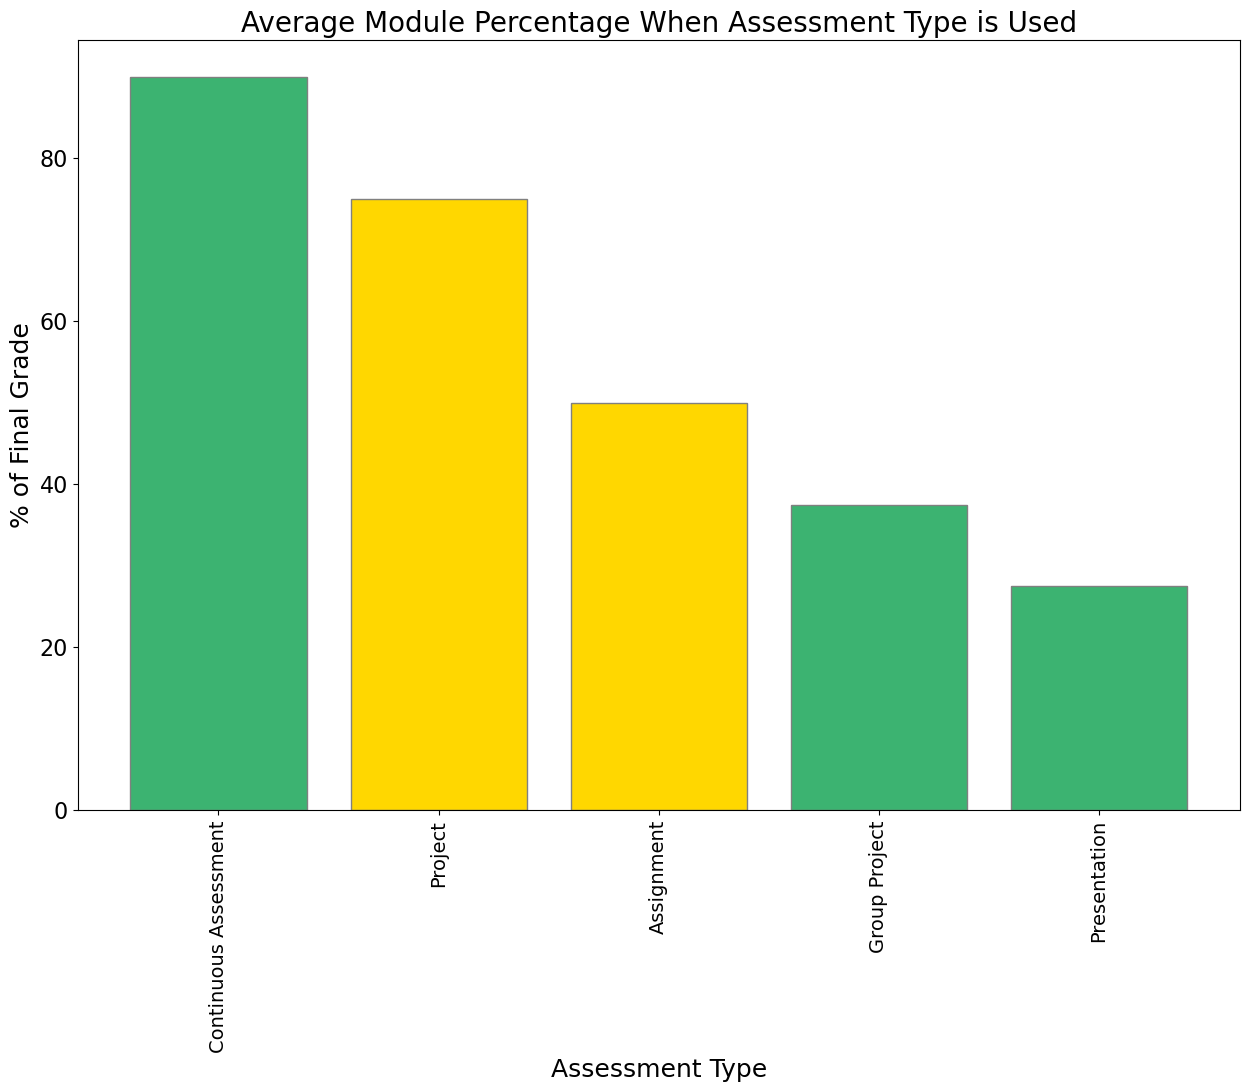

In [20]:
import matplotlib.pyplot as plt

fig, ax=plt.subplots( figsize=(15, 10))

#barWidth=0.25
colormap={"Essay": "gold", "Assignment": "gold", "Examination": "mediumseagreen", "Attendance": "mediumseagreen", \
          "Class Test":"mediumseagreen", "Continuous Assessment": "gold", "Fieldwork": "mediumseagreen", "Group Project": "gold",\
         "Journal": "gold", "Lab Report" : "mediumseagreen", "Multiple Choice Questionnaire (MCQ)": "mediumseagreen", \
          "Oral Examination" : "mediumseagreen", "Portfolio": "gold", "Practical Examination": "mediumseagreen",\
          "Presentation":"mediumseagreen", "Project": "gold", "Seminar": "mediumseagreen",\
          "Studio Examination": "mediumseagreen", "Assessments worth <2%": "mediumseagreen"}

# Make the plot
ax.bar(sorted_averages["Assessment Type"], sorted_averages["% of Final Grade"], edgecolor="grey", color=["mediumseagreen", "gold", \
"gold", "mediumseagreen", "mediumseagreen", "gold", "gold",  "mediumseagreen", "gold", "gold", "gold", "mediumseagreen",\
                                                                                       "mediumseagreen", "mediumseagreen", \
                                                "mediumseagreen", "gold", "mediumseagreen", "mediumseagreen"] )


#Set the options for the axes
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', rotation=90, labelsize=14)
#ax.legend(fontsize=20)
ax.set_xlabel("Assessment Type", fontsize=18)
ax.set_ylabel("% of Final Grade",fontsize=18)
#Add the date lines for context
ax.set_title("Average Module Percentage When Assessment Type is Used", fontsize=20)

In [21]:
assessment_total=assessments.groupby(by="Assessment Type", as_index=False).sum()
 
assessment_total

,Assessment Type,% of Final Grade
0,Assignment,650
1,Continuous Assessment,270
2,Group Project,75
3,Presentation,55
4,Project,150


In [22]:
total=assessment_total["% of Final Grade"].sum()

assessment_total["% of Assessment"]=assessment_total["% of Final Grade"].apply(lambda x: x/total)
assessment_total["Assessment Type"]=assessment_total["Assessment Type"].cat.add_categories("Assessments worth <2%")
assessment_total.loc[assessment_total["% of Assessment"] < 0.02, "Assessment Type"] = "Assessments worth <2%"

assessment_total

,Assessment Type,% of Final Grade,% of Assessment
0,Assignment,650,0.541667
1,Continuous Assessment,270,0.225000
2,Group Project,75,0.062500
3,Presentation,55,0.045833
4,Project,150,0.125000


In [23]:
assessment_total["Assessment Type"]= assessment_total["Assessment Type"].cat.remove_categories(["Fieldwork", "Journal", \
                                                                             "Attendance", "Oral Examination", \
                                                "Practical Examination", "Seminar", "Studio Examination",\
                                                                                             "Multiple Choice Questionnaire"])

assessment_total

ValueError: removals must all be in old categories: {'Oral Examination', 'Attendance', 'Studio Examination', 'Practical Examination', 'Multiple Choice Questionnaire', 'Fieldwork', 'Journal', 'Seminar'}

In [ ]:
filtered_asses=assessment_total.groupby(by="Assessment Type").sum()

pie_assessment=filtered_asses["% of Assessment"]

sorted_totals=pie_assessment.sort_values(ascending=False)

sorted_totals

In [ ]:
fig, ax=plt.subplots(figsize=(15,12))

#exploded=[0.03, 0, 0.03, 0.03, 0, 0.03, 0.03, 0.03, 0, 0, 0]
ax.pie(sorted_totals, wedgeprops = { 'linewidth' : 0.5, 'edgecolor' : 'grey' }, \
       autopct="%1.1f%%", labels=sorted_totals.index, colors=["gold","mediumseagreen", \
"gold", "gold", "mediumseagreen",  "gold", "gold", "gold", "mediumseagreen",\
                                                              "mediumseagreen", "mediumseagreen", "mediumseagreen"])

#my_circle=ax.Circle( (0,0), 0.7, color='white')
#p=ax.gcf()

ax.set_title("Assessment type as a Percentage of Module Assessments", fontsize=20)